# Client Graph
Notebook to manipulate a dask graph at the client stage.

## Example 1: Edit submit method

In [1]:
from dask.distributed import Client

# Create a Dask client
client = Client()

original_submit = client.submit

In [2]:
def modified_submit(*args, **kwargs):
    print("Entered Submit")
    print("Party if it works")
    return original_submit(*args, **kwargs)

In [3]:
client.submit = modified_submit

In [4]:
def neg(x):
    return -x


client.submit(neg, 3)

Entered Submit
Party if it works


<Future: pending, key: neg-6509467a9c66ce2389f8f71ccfe663b3>

In [5]:
client.shutdown()

2024-06-19 19:37:55,387 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:16903' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'neg-6509467a9c66ce2389f8f71ccfe663b3'} (stimulus_id='handle-worker-cleanup-1718822275.387008')


## Example 2: Edit collections_to_dsk method

In [6]:
from dask.distributed import Client
import dask
import dask.array as da

from datetime import datetime

client = Client()

# Save original collections_to_dsk method
original_collections_to_dsk = client.collections_to_dsk

In [7]:
def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))
    print("Dask Graph Tasks")
    for collection in collections:
        print(f"Task Name: {collection.name}")
    print("-----------------\n")

    return original_collections_to_dsk(collections, *args, **kwargs)


client.collections_to_dsk = modified_collections_to_dsk
print("collections_to_dsk method has been replaced")

collections_to_dsk method has been replaced


In [8]:
x = da.ones((1000, 1000), chunks=(100, 100))
y = x + 1
z = y.mean()

In [9]:
result = client.compute(z)

Inside myFunc. Time = 19:38:18
Dask Graph Tasks
Task Name: mean_agg-aggregate-c50263a0ad47c330577b3058195ad928
-----------------



In [10]:
client.shutdown()

2024-06-19 19:38:31,549 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:21019' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-3daf4f11543bcdbd0d181b8d6c929af3'} (stimulus_id='handle-worker-cleanup-1718822311.5493789')


## Example 3: Replace a Task Graph

### Example 3.1: Keep client running
This will cause an issue as the client still has memory of the task and hash

In [11]:
from dask.distributed import Client
import dask
import dask.array as da
from dask.highlevelgraph import HighLevelGraph
from datetime import datetime

client = Client()

original_collections_to_dsk = client.collections_to_dsk

In [12]:
existing_functions = []


def add_to_three(number):
    return number + 3


def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")
    global existing_functions
    for funcs in existing_functions:
        print(f"{funcs}")

    print("Dask Graph Tasks")
    for collection in collections:
        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(collection.dask)
        if collection.name not in existing_functions:
            print(f"Adding {collection.name} to existing_functions")
            existing_functions.append(collection.name)
        else:
            print(f"{collection.name} has already been processed")
            # TODO: Continue playing around with the dask graph so return is not a string
            # TODO: Use collection hash rather than collection name
            layers = {
                f"add_to_three-{(collection.name)}": {
                    (f"add_to_three-{(collection.name)}", 0): (add_to_three, 20)
                }
            }
            dependencies = {f"add_to_three-{(collection.name)}": set()}
            graph = HighLevelGraph(layers, dependencies)
            collection.dask = graph
            print("New Dask Graph")
            print(collection.dask)

    print("-----------------")

    return original_collections_to_dsk(collections, *args, **kwargs)


client.collections_to_dsk = modified_collections_to_dsk

In [13]:
x = da.ones((1000, 1000), chunks=(100, 100))
y = x + 1
z = y.mean()

In [14]:
result = client.compute(z)

Inside myFunc. Time = 19:40:19
Functions already processed
Dask Graph Tasks
Task Name: mean_agg-aggregate-c50263a0ad47c330577b3058195ad928
Dask Graph
HighLevelGraph with 7 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-098526cf93d1ac0d3a8744f59d0814fb
 2. mean_chunk-4e5168d025885dfbdfd76df3f8083cda
 3. mean_combine-partial-0832826c732652f3243668d740a0d5f3
 4. mean_combine-partial-f33215f12dcb169d48ded3405ae5b4a2
 5. mean_combine-partial-f380b3499d120118c907e62d760350cc
 6. mean_agg-aggregate-c50263a0ad47c330577b3058195ad928

Adding mean_agg-aggregate-c50263a0ad47c330577b3058195ad928 to existing_functions
-----------------


In [15]:
result

<Future: finished, type: numpy.float64, key: finalize-3daf4f11543bcdbd0d181b8d6c929af3>

In [16]:
result.result()

2.0

In [17]:
# Compute a second time
result = client.compute(z)

Inside myFunc. Time = 19:40:23
Functions already processed
mean_agg-aggregate-c50263a0ad47c330577b3058195ad928
Dask Graph Tasks
Task Name: mean_agg-aggregate-c50263a0ad47c330577b3058195ad928
Dask Graph
HighLevelGraph with 7 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-098526cf93d1ac0d3a8744f59d0814fb
 2. mean_chunk-4e5168d025885dfbdfd76df3f8083cda
 3. mean_combine-partial-0832826c732652f3243668d740a0d5f3
 4. mean_combine-partial-f33215f12dcb169d48ded3405ae5b4a2
 5. mean_combine-partial-f380b3499d120118c907e62d760350cc
 6. mean_agg-aggregate-c50263a0ad47c330577b3058195ad928

mean_agg-aggregate-c50263a0ad47c330577b3058195ad928 has already been processed
New Dask Graph
HighLevelGraph with 1 layers.
 0. add_to_three-mean_agg-aggregate-c50263a0ad47c330577b3058195ad928

-----------------


2024-06-19 19:40:23,945 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'finalize-3daf4f11543bcdbd0d181b8d6c929af3' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: memory
old run_spec: (<function finalize at 0x7f96080ec280>, ([('mean_agg-aggregate-c50263a0ad47c330577b3058195ad928',)],), {})
new run_spec: (<function finalize at 0x7f96080ec280>, ([('mean_agg-aggregate-c50263a0ad47c330577b3058195ad928',)],), {})
old token: ('tuple', [('ae65af090ad79ae2e434bc4c7eb750244a1a40bb', []), ('tuple', [('list', [('tuple', ['mean_agg-aggregate-c50263a0ad47c330577b3058195ad928'])])]), ('dict', [])])
new token: ('tuple', [('ae65af090ad

In [18]:
client.shutdown()

2024-06-19 19:40:46,904 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:13361' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-3daf4f11543bcdbd0d181b8d6c929af3'} (stimulus_id='handle-worker-cleanup-1718822446.9042947')


### Example 3.2: Edit HighLevelGraph in a new cluster

In [19]:
from dask.distributed import Client
import dask
import dask.array as da
from dask.highlevelgraph import HighLevelGraph
from datetime import datetime

In [20]:
client = Client()

original_collections_to_dsk = client.collections_to_dsk

In [21]:
existing_functions = ["mean_agg-aggregate-c50263a0ad47c330577b3058195ad928"]


def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")
    global existing_functions
    for funcs in existing_functions:
        print(f"{funcs}")

    print("Dask Graph Tasks")
    for collection in collections:
        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(collection.dask)
        if collection.name not in existing_functions:
            print(f"Adding {collection.name} to existing_functions")
            existing_functions.append(collection.name)
        else:
            print(f"{collection.name} has already been processed")
            # TODO: Continue playing around with the dask graph so return is not a string
            # TODO: Use collection hash rather than collection name
            layers = {
                f"add_to_three-{(collection.name)}": {
                    (f"add_to_three-{(collection.name)}", 0): (add_to_three, 20)
                }
            }
            dependencies = {f"add_to_three-{(collection.name)}": set()}
            graph = HighLevelGraph(layers, dependencies)
            collection.dask = graph
            # layers = {f"add_to_thre11e-{(collection.name)}": {(f"add_to_three-{(collection.name)}", 0): (add_to_three, 20)}}
            # layers = {f"add_to_thre11e-{(collection.name)}": (add_to_three, 20)}
            # dependencies = {f"add_to_three-{(collection.name)}": set()}
            # graph = HighLevelGraph(layers, dependencies)
            # collection.dask = graph
            print("New Dask Graph")
            print(collection.dask)

    print("-----------------")

    return original_collections_to_dsk(collections, *args, **kwargs)

In [22]:
client.collections_to_dsk = modified_collections_to_dsk

In [23]:
def add_to_three(number):
    return number + 3

In [24]:
x = da.ones((1000, 1000), chunks=(100, 100))
y = x + 1
z = y.mean()
result = client.compute(z)

Inside myFunc. Time = 19:43:16
Functions already processed
mean_agg-aggregate-c50263a0ad47c330577b3058195ad928
Dask Graph Tasks
Task Name: mean_agg-aggregate-c50263a0ad47c330577b3058195ad928
Dask Graph
HighLevelGraph with 7 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-098526cf93d1ac0d3a8744f59d0814fb
 2. mean_chunk-4e5168d025885dfbdfd76df3f8083cda
 3. mean_combine-partial-0832826c732652f3243668d740a0d5f3
 4. mean_combine-partial-f33215f12dcb169d48ded3405ae5b4a2
 5. mean_combine-partial-f380b3499d120118c907e62d760350cc
 6. mean_agg-aggregate-c50263a0ad47c330577b3058195ad928

mean_agg-aggregate-c50263a0ad47c330577b3058195ad928 has already been processed
New Dask Graph
HighLevelGraph with 1 layers.
 0. add_to_three-mean_agg-aggregate-c50263a0ad47c330577b3058195ad928

-----------------


In [25]:
result

<Future: finished, type: str, key: finalize-3daf4f11543bcdbd0d181b8d6c929af3>

In [26]:
result.result()

'mean_agg-aggregate-c50263a0ad47c330577b3058195ad928'

### Example 3.3: Try with blockwise

In [5]:
from dask.distributed import Client
import dask
import dask.array as da
import numpy as np
from dask.highlevelgraph import HighLevelGraph
from datetime import datetime
from dask.array.core import Array

client = Client()

# Define some simple functions to use in the graph
def add(x, y):
    return x + y


def multiply(x, y):
    return x * y


# Create a Dask array from the HighLevelGraph
# Note: We need to specify the shape and chunks of the resulting array
dask_array = da.blockwise(
    lambda x, y: multiply(add(x, y), y),
    "i",
    np.array([1, 2, 3]),
    "i",
    np.array([4, 5, 6]),
    "i",
    dtype=np.int64,
)

# Use client.compute to compute the result
future = client.compute(dask_array)
result = future.result()

client.shutdown()

print("------------")
print(result)

/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 16985 instead
  warnings.warn(
2024-06-24 22:40:59,285 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:16327' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-99beb22034172632fdd161427fa0c2cc'} (stimulus_id='handle-worker-cleanup-1719265259.285501')


------------
[20 35 54]


In [6]:
from dask.distributed import Client
import dask
import dask.array as da
import numpy as np
from dask.highlevelgraph import HighLevelGraph
from datetime import datetime
from dask.array.core import Array


def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")

    print("Dask Graph Tasks")
    for collection in collections:
        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(collection.dask)
        print("-----------------")
        print("Edditing Dask Graph")
        dask_array = da.blockwise(
            lambda x, y: multiply(add(x, y), y),
            "i",
            np.array([5, 6, 7]),
            "i",
            np.array([8, 9, 10]),
            "i",
            dtype=np.int64,
        )
        collection.dask = dask_array.dask
        collection.__dask_keys__ = dask_array.__dask_keys__

        print("New Dask Graph")
        print(collection.dask)

    print("-----------------")

    return original_collections_to_dsk(collections, *args, **kwargs)


client = Client()

original_collections_to_dsk = client.collections_to_dsk

client.collections_to_dsk = modified_collections_to_dsk

# Define some simple functions to use in the graph
def add(x, y):
    return x + y


def multiply(x, y):
    return x * y


# Create a Dask array from the HighLevelGraph
# Note: We need to specify the shape and chunks of the resulting array
dask_array = da.blockwise(
    lambda x, y: multiply(add(x, y), y),
    "i",
    np.array([1, 2, 3]),
    "i",
    np.array([4, 5, 6]),
    "i",
    dtype=np.int64,
)

# Use client.compute to compute the result
future = client.compute(dask_array)
result = future.result()

client.shutdown()

print("------------")
print(result)

/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 25436 instead
  warnings.warn(


Inside myFunc. Time = 22:41:44
Functions already processed
Dask Graph Tasks
Task Name: lambda-bd96b5ee7bd8b34908deaa71441f1d4a
Dask Graph
HighLevelGraph with 3 layers.
 0. array-93899268a02d75f85755ccb59b755ad1
 1. array-08b8023b2db8bebf73813d166e3f6b63
 2. lambda-bd96b5ee7bd8b34908deaa71441f1d4a

-----------------
Edditing Dask Graph
New Dask Graph
HighLevelGraph with 3 layers.
 0. array-71a7394e5f14de7dc72bb0b1b251ce84
 1. array-e3622cdb87acdb3eed57eec6c2ef9fb7
 2. lambda-19e9145bca12a9b712321a40e73e64bd

-----------------


2024-06-24 22:41:45,478 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:21393' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-a78071afc5b678a3bf5936b8a138ce3f'} (stimulus_id='handle-worker-cleanup-1719265305.478143')


------------
[104 135 170]


### Example 3.4: ones and blockwise

In this example, a HighLevelGraph containing two tasks is submitted to the client.
Prior to being sent to the scheduler, the HighLevelGraph is replaced with a HighLevelGraph defined by blockwise.


In [1]:
from dask.distributed import Client
import dask
import dask.array as da
import numpy as np
from dask.highlevelgraph import HighLevelGraph
from datetime import datetime
from dask.array.core import Array


def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")

    print("Dask Graph Tasks")
    for collection in collections:
        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(collection.dask)
        print("-----------------")
        print("Edditing Dask Graph")
        dask_array = da.blockwise(
            lambda x, y: multiply(add(x, y), y),
            "i",
            np.array([5, 6, 7]),
            "i",
            np.array([8, 9, 10]),
            "i",
            dtype=np.int64,
        )
        collection.dask = dask_array.dask
        collection.__dask_keys__ = dask_array.__dask_keys__

        print("New Dask Graph")
        print(collection.dask)

    print("-----------------")

    return original_collections_to_dsk(collections, *args, **kwargs)


client = Client()

original_collections_to_dsk = client.collections_to_dsk

client.collections_to_dsk = modified_collections_to_dsk

# Define some simple functions to use in the graph
def add(x, y):
    return x + y


def multiply(x, y):
    return x * y


# Create a Dask array from the HighLevelGraph
# Note: We need to specify the shape and chunks of the resulting array
dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 1


# Use client.compute to compute the result
future = client.compute(dask_array)
result = future.result()

client.shutdown()

print("------------")
print(result)

Inside myFunc. Time = 16:05:15
Functions already processed
Dask Graph Tasks
Task Name: add-098526cf93d1ac0d3a8744f59d0814fb
Dask Graph
HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-098526cf93d1ac0d3a8744f59d0814fb

-----------------
Edditing Dask Graph
New Dask Graph
HighLevelGraph with 3 layers.
 0. array-71a7394e5f14de7dc72bb0b1b251ce84
 1. array-e3622cdb87acdb3eed57eec6c2ef9fb7
 2. lambda-75f9fecc0d97ebf395a496c2575f03d0

-----------------


2024-06-25 16:05:15,426 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:13193' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-c0d5d498f2169d9602849de30cd6a0a0'} (stimulus_id='handle-worker-cleanup-1719327915.4264529')


------------
[104 135 170]


## Example 4: Hashing

### Example 4.1: Hashing

In this example, a hash is created using hashlib. 
dask.tokenize is not used as it is not repeatable in different environments.

Expected hash is `ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8`

In [1]:
import dask.array as da
import hashlib

dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231
graph = dask_array.__dask_graph__()
print(graph)

HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d



In [2]:
total_graph_description = []
for i, (layer_name, layer) in enumerate(graph.layers.items()):
    print(f"Layer: {layer_name}")
    short_layer_name = layer_name[: layer_name.rfind("-")]
    print(f"short_layer_name: {short_layer_name}")
    print(f"len: {len(layer.items())}")
    # Lazy looping to get the args of one layer.
    # Possible extension would get all hash of each layer
    for task_key, task in layer.items():
        function = task[0]
        args = task[1:]
    print(f"args: {args}")
    if i == 0:
        print(f"args: {args[0]}")
        layer_args = args[0]

    else:
        print(f"args: {args[1]}")
        layer_args = args[1]
    print(f"function: {function}")
    layer_description = {
        "function:": short_layer_name,
        "layer_length": len(layer.items()),
        "layer_args": layer_args,
    }
    total_graph_description.append(layer_description)
    print("----------------------")

print("total graph description:")
print(total_graph_description)

Layer: ones_like-c53a97836143a00162e3470fef213e1e
short_layer_name: ones_like
len: 100
args: ((100, 100),)
args: (100, 100)
function: subgraph_callable-f646aaf1ae08e118dd013a3d16eb54ec
----------------------
Layer: add-34435cc4a153f02b208c5e30ee811e3d
short_layer_name: add
len: 100
args: (('ones_like-c53a97836143a00162e3470fef213e1e', 9, 9), 20231)
args: 20231
function: subgraph_callable-67aaf28825d396a0abf7512dfd79c838
----------------------
total graph description:
[{'function:': 'ones_like', 'layer_length': 100, 'layer_args': (100, 100)}, {'function:': 'add', 'layer_length': 100, 'layer_args': 20231}]


In [3]:
hashlib.sha3_384(str(total_graph_description).encode()).hexdigest()

'ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8'

`ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8`

is the expected result

In [4]:
dask_array.compute()

array([[20232., 20232., 20232., ..., 20232., 20232., 20232.],
       [20232., 20232., 20232., ..., 20232., 20232., 20232.],
       [20232., 20232., 20232., ..., 20232., 20232., 20232.],
       ...,
       [20232., 20232., 20232., ..., 20232., 20232., 20232.],
       [20232., 20232., 20232., ..., 20232., 20232., 20232.],
       [20232., 20232., 20232., ..., 20232., 20232., 20232.]])

### Example 4.2: Move the hash determination into collections_to_dsk

In [1]:
import dask.array as da
import hashlib
from datetime import datetime
from dask.distributed import Client
from pprint import pprint

In [2]:
def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")

    print("Dask Graph Tasks")
    for collection in collections:
        graph = collection.dask

        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(graph)
        total_graph_description = []
        for i, (layer_name, layer) in enumerate(graph.layers.items()):
            short_layer_name = layer_name[: layer_name.rfind("-")]
            task_key, task = next(iter(layer.items()))
            function = task[0]
            task_args = task[1:]
            if i == 0:
                layer_args = task_args[0]
            else:
                layer_args = task_args[1]

            layer_description = {
                "function:": short_layer_name,
                "layer_length": len(layer.items()),
                "layer_args": layer_args,
            }
            total_graph_description.append(layer_description)
        print("total_graph_description:")
        pprint(total_graph_description)
        graph_hash = hashlib.sha3_384(str(total_graph_description).encode()).hexdigest()
        print(f"hash: \033[93m {graph_hash} \033[0m")

    print("----------------------")

    return original_collections_to_dsk(collections, *args, **kwargs)

In [3]:
client = Client()

original_collections_to_dsk = client.collections_to_dsk

client.collections_to_dsk = modified_collections_to_dsk

dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231

# Use client.compute to compute the result
future = client.compute(dask_array)
result = future.result()

client.shutdown()

print("------------")
print(result)

Inside myFunc. Time = 20:57:57
Functions already processed
Dask Graph Tasks
Task Name: add-34435cc4a153f02b208c5e30ee811e3d
Dask Graph
HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d

total_graph_description:
[{'function:': 'ones_like', 'layer_args': (100, 100), 'layer_length': 100},
 {'function:': 'add', 'layer_args': 20231, 'layer_length': 100}]
hash:  ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8 
----------------------


2024-07-02 20:57:58,396 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:5373' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-236d3b698353fe74f1e05c293988becb'} (stimulus_id='handle-worker-cleanup-1719950278.395871')


------------
[[20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 ...
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]]


### Example 4.3: Change graph based on hash

In [1]:
import dask.array as da
import hashlib
from datetime import datetime
from dask.distributed import Client
from pprint import pprint
import numpy as np

In [2]:
def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")

    global existing_hashes

    print("Dask Graph Tasks")
    for collection in collections:
        graph = collection.dask

        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(graph)
        total_graph_description = []
        for i, (layer_name, layer) in enumerate(graph.layers.items()):
            short_layer_name = layer_name[: layer_name.rfind("-")]
            task_key, task = next(iter(layer.items()))
            function = task[0]
            task_args = task[1:]
            if i == 0:
                layer_args = task_args[0]
            else:
                layer_args = task_args[1]

            layer_description = {
                "function:": short_layer_name,
                "layer_length": len(layer.items()),
                "layer_args": layer_args,
            }
            total_graph_description.append(layer_description)
        print("total_graph_description:")
        pprint(total_graph_description)
        graph_hash = hashlib.sha3_384(str(total_graph_description).encode()).hexdigest()
        print(f"hash: \033[93m {graph_hash} \033[0m")
        if graph_hash in existing_hashes:
            print("\nGraph found in existing_hashes... replacing graph")
            dask_array = da.blockwise(
                lambda x, y: multiply(add(x, y), y),
                "i",
                np.array([5, 6, 7]),
                "i",
                np.array([8, 9, 10]),
                "i",
                dtype=np.int64,
            )
            collection.dask = dask_array.dask
            collection.__dask_keys__ = dask_array.__dask_keys__
            print("New Dask Graph")
            print(collection.dask)
    print("----------------------")

    return original_collections_to_dsk(collections, *args, **kwargs)

In [3]:
existing_hashes = [
    "ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8"
]


def add(x, y):
    return x + y


def multiply(x, y):
    return x * y

In [4]:
client = Client()

original_collections_to_dsk = client.collections_to_dsk

client.collections_to_dsk = modified_collections_to_dsk

dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231

# Use client.compute to compute the result
future = client.compute(dask_array)
result = future.result()

client.shutdown()

print("------------")
print(result)

Inside myFunc. Time = 20:57:24
Functions already processed
Dask Graph Tasks
Task Name: add-34435cc4a153f02b208c5e30ee811e3d
Dask Graph
HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d

total_graph_description:
[{'function:': 'ones_like', 'layer_args': (100, 100), 'layer_length': 100},
 {'function:': 'add', 'layer_args': 20231, 'layer_length': 100}]
hash:  ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8 

Graph found in existing_hashes... replacing graph
New Dask Graph
HighLevelGraph with 3 layers.
 0. array-71a7394e5f14de7dc72bb0b1b251ce84
 1. array-e3622cdb87acdb3eed57eec6c2ef9fb7
 2. lambda-83b0b2050c699e9e26592de20f8e625b

----------------------


2024-07-02 20:57:25,128 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:25830' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-236d3b698353fe74f1e05c293988becb'} (stimulus_id='handle-worker-cleanup-1719950245.1277432')


------------
[104 135 170]


### Example 4.4: Increase graph complexity for hash

This highlights one of the difficaulting of getting a functions arguments. 
Sometimes the task_args is a list of tuples.

In [1]:
import dask.array as da
import hashlib
from pprint import pprint

In [2]:
def get_graph_layers(graph):
    print("graph")
    pprint(graph)
    print("-----------------------------------")
    for i, (layer_name, layer) in enumerate(graph.layers.items()):
        short_layer_name = layer_name[: layer_name.rfind("-")]
        task_key, task = next(iter(layer.items()))
        function = task[0]
        task_args = task[1:]
        print(f"layer {i}")
        print(f"function: {short_layer_name}")
        print(f"task_args: {task_args}")
        print("-----------------------------------")

In [3]:
dask_array = da.ones((100, 100), chunks=(100, 100)) + 20231
complex_dask_array = dask_array.mean()
simple_graph = dask_array.dask
complex_graph = complex_dask_array.dask

In [4]:
get_graph_layers(simple_graph)

graph
HighLevelGraph with 2 layers.
 0. ones_like-28c9cae68f942f8b695446a89cd7648f
 1. add-aaf5cfbf1c212eb783889117ff533b5a

-----------------------------------
layer 0
function: ones_like
task_args: ((100, 100),)
-----------------------------------
layer 1
function: add
task_args: (('ones_like-28c9cae68f942f8b695446a89cd7648f', 0, 0), 20231)
-----------------------------------


In [5]:
get_graph_layers(complex_graph)

graph
HighLevelGraph with 4 layers.
 0. ones_like-28c9cae68f942f8b695446a89cd7648f
 1. add-aaf5cfbf1c212eb783889117ff533b5a
 2. mean_chunk-3aa3271bdf64f79fa8abf07b12eb1305
 3. mean_agg-aggregate-ac691a2688d4b54a1bce95970905fce1

-----------------------------------
layer 0
function: ones_like
task_args: ((100, 100),)
-----------------------------------
layer 1
function: add
task_args: (('ones_like-28c9cae68f942f8b695446a89cd7648f', 0, 0), 20231)
-----------------------------------
layer 2
function: mean_chunk
task_args: (('add-aaf5cfbf1c212eb783889117ff533b5a', 0, 0),)
-----------------------------------
layer 3
function: mean_agg-aggregate
task_args: ([[('mean_chunk-3aa3271bdf64f79fa8abf07b12eb1305', 0, 0)]],)
-----------------------------------


In [6]:
dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231
complex_dask_array = dask_array.mean()
simple_graph = dask_array.dask
complex_graph = complex_dask_array.dask

In [7]:
get_graph_layers(simple_graph)

graph
HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d

-----------------------------------
layer 0
function: ones_like
task_args: ((100, 100),)
-----------------------------------
layer 1
function: add
task_args: (('ones_like-c53a97836143a00162e3470fef213e1e', 0, 0), 20231)
-----------------------------------


In [8]:
get_graph_layers(complex_graph)

graph
HighLevelGraph with 7 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d
 2. mean_chunk-fe9277ba8994ee27c6bb4e799a51706f
 3. mean_combine-partial-89593f47b9e82ecdc97833a1289ab5a9
 4. mean_combine-partial-0425fc2319495f2d7819484790b30613
 5. mean_combine-partial-9e2d74724eb72b408a695fce97bf9ad3
 6. mean_agg-aggregate-42197768bf4bef77e6dbd8fdd78c5b69

-----------------------------------
layer 0
function: ones_like
task_args: ((100, 100),)
-----------------------------------
layer 1
function: add
task_args: (('ones_like-c53a97836143a00162e3470fef213e1e', 0, 0), 20231)
-----------------------------------
layer 2
function: mean_chunk
task_args: (('add-34435cc4a153f02b208c5e30ee811e3d', 0, 0),)
-----------------------------------
layer 3
function: mean_combine-partial
task_args: ([[('mean_chunk-fe9277ba8994ee27c6bb4e799a51706f', 0, 0), ('mean_chunk-fe9277ba8994ee27c6bb4e799a51706f', 0, 1)], [('mean_chunk-fe9277ba8994ee27c6bb4e799a51706f', 1,

## Example 5: Intercepting Futures

### Example 5.1: Write result to file before it's returned

In [9]:
import dask.array as da
from datetime import datetime
from dask.distributed import Client
import numpy as np

In [21]:
def modified_compute(*args, **kwargs):
    print("Inside modified_compute. Time = " + datetime.now().strftime("%H:%M:%S"))
    print("Intercepting Compute")
    future = original_compute(*args, **kwargs)
    # wait for the future to complete
    result = future.result()
    print("Compute Completed")
    global hash
    output_save_loc = "/shared/scratch/ak18773/dask-dirac/" + hash + ".npy"
    np.save(output_save_loc, result, allow_pickle=True)
    print(f"Output Written to: {output_save_loc}")
    print("-------------------------------")
    return result

In [22]:
client = Client()

hash = "example_5_1"
dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231
original_compute = client.compute
client.compute = modified_compute

# Returning the result rather than a future now
result = client.compute(dask_array)
client.shutdown()

print(result)

/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 15087 instead
  warnings.warn(


Inside modified_compute. Time = 17:13:16
Intercepting Compute
Compute Completed
Output Written to: /shared/scratch/ak18773/dask-dirac/example_5_1.npy
-------------------------------
[[20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 ...
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]]


## Example 6: Caching

### Example 6.1: Determine hash in collections_to_dsk and save result in compute

In [1]:
import dask.array as da
import hashlib
from datetime import datetime
from dask.distributed import Client
from pprint import pprint
import numpy as np

In [2]:
def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")

    global existing_hashes

    print("Dask Graph Tasks")
    for collection in collections:
        graph = collection.dask

        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(graph)
        total_graph_description = []
        for i, (layer_name, layer) in enumerate(graph.layers.items()):
            short_layer_name = layer_name[: layer_name.rfind("-")]
            task_key, task = next(iter(layer.items()))
            function = task[0]
            task_args = task[1:]
            if i == 0:
                layer_args = task_args[0]
            else:
                layer_args = task_args[1]

            layer_description = {
                "function:": short_layer_name,
                "layer_length": len(layer.items()),
                "layer_args": layer_args,
            }
            total_graph_description.append(layer_description)
        print("total_graph_description:")
        pprint(total_graph_description)
        graph_hash = hashlib.sha3_384(str(total_graph_description).encode()).hexdigest()
        print(f"hash: \033[93m {graph_hash} \033[0m")
        if graph_hash in existing_hashes:
            print("\nGraph found in existing_hashes... replacing graph")
            output_save_loc = (
                "/shared/scratch/ak18773/dask-dirac/" + graph_hash + ".npy"
            )
            dask_array = da.blockwise(
                np.load,
                "",
                output_save_loc,
                None,
                dtype=np.int64,
            )
            collection.dask = dask_array.dask
            collection.__dask_keys__ = dask_array.__dask_keys__
            print("New Dask Graph")
            print(collection.dask)
        existing_hashes.append(graph_hash)
    print("----------------------")

    return original_collections_to_dsk(collections, *args, **kwargs)

In [3]:
def modified_compute(*args, **kwargs):
    print("Inside modified_compute. Time = " + datetime.now().strftime("%H:%M:%S"))
    print("Intercepting Compute")
    future = original_compute(*args, **kwargs)
    # wait for the future to complete
    result = future.result()
    print("Compute Completed")
    global existing_hashes
    hash = existing_hashes[-1]
    output_save_loc = "/shared/scratch/ak18773/dask-dirac/" + hash + ".npy"
    if os.path.isfile(output_save_loc):
        print(f"File already exists at: {output_save_loc}")
        print("Skipping write")
    else:
        np.save(output_save_loc, result, allow_pickle=True)
        print(f"Output Written to: {output_save_loc}")
    print("-------------------------------")
    return result

In [4]:
existing_hashes = []

dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231

client = Client()

# Replace functions
original_collections_to_dsk = client.collections_to_dsk
client.collections_to_dsk = modified_collections_to_dsk
original_compute = client.compute
client.compute = modified_compute


result = client.compute(dask_array)

client.shutdown()

print("------------")
print(result)

Inside modified_compute. Time = 17:24:15
Intercepting Compute
Inside myFunc. Time = 17:24:15
Functions already processed
Dask Graph Tasks
Task Name: add-34435cc4a153f02b208c5e30ee811e3d
Dask Graph
HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d

total_graph_description:
[{'function:': 'ones_like', 'layer_args': (100, 100), 'layer_length': 100},
 {'function:': 'add', 'layer_args': 20231, 'layer_length': 100}]
hash:  ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8 
----------------------
Compute Completed
Output Written to: /shared/scratch/ak18773/dask-dirac/ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8.npy
-------------------------------
------------
[[20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 ...
 [20232. 20232. 2023

### Example 6.2: Same as 6.1 but check if file exists to avoid overwriting file

In [1]:
import dask.array as da
import hashlib
from datetime import datetime
from dask.distributed import Client
from pprint import pprint
import numpy as np
import os

In [2]:
def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")

    global existing_hashes

    print("Dask Graph Tasks")
    for collection in collections:
        graph = collection.dask

        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(graph)
        total_graph_description = []
        for i, (layer_name, layer) in enumerate(graph.layers.items()):
            short_layer_name = layer_name[: layer_name.rfind("-")]
            task_key, task = next(iter(layer.items()))
            function = task[0]
            task_args = task[1:]
            if i == 0:
                layer_args = task_args[0]
            else:
                layer_args = task_args[1]

            layer_description = {
                "function:": short_layer_name,
                "layer_length": len(layer.items()),
                "layer_args": layer_args,
            }
            total_graph_description.append(layer_description)
        print("total_graph_description:")
        pprint(total_graph_description)
        graph_hash = hashlib.sha3_384(str(total_graph_description).encode()).hexdigest()
        print(f"hash: \033[93m {graph_hash} \033[0m")
        if graph_hash in existing_hashes:
            print("\nGraph found in existing_hashes... replacing graph")
            output_save_loc = (
                "/shared/scratch/ak18773/dask-dirac/" + graph_hash + ".npy"
            )
            dask_array = da.blockwise(
                np.load,
                "",
                output_save_loc,
                None,
                dtype=np.int64,
            )
            collection.dask = dask_array.dask
            collection.__dask_keys__ = dask_array.__dask_keys__
            print("New Dask Graph")
            print(collection.dask)
        existing_hashes.append(graph_hash)
    print("----------------------")

    return original_collections_to_dsk(collections, *args, **kwargs)

In [3]:
def modified_compute(*args, **kwargs):
    print("Inside modified_compute. Time = " + datetime.now().strftime("%H:%M:%S"))
    print("Intercepting Compute")
    future = original_compute(*args, **kwargs)
    # wait for the future to complete
    result = future.result()
    print("Compute Completed")
    global existing_hashes
    hash = existing_hashes[-1]
    output_save_loc = "/shared/scratch/ak18773/dask-dirac/" + hash + ".npy"
    if os.path.isfile(output_save_loc):
        print(f"File already exists at: {output_save_loc}")
        print("Skipping write")
    else:
        np.save(output_save_loc, result, allow_pickle=True)
        print(f"Output Written to: {output_save_loc}")
    print("-------------------------------")
    return result

In [4]:
existing_hashes = []

dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231

client = Client()

# Replace functions
original_collections_to_dsk = client.collections_to_dsk
client.collections_to_dsk = modified_collections_to_dsk
original_compute = client.compute
client.compute = modified_compute


result = client.compute(dask_array)

client.shutdown()

print("------------")
print(result)

Inside modified_compute. Time = 17:38:08
Intercepting Compute
Inside myFunc. Time = 17:38:08
Functions already processed
Dask Graph Tasks
Task Name: add-34435cc4a153f02b208c5e30ee811e3d
Dask Graph
HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d

total_graph_description:
[{'function:': 'ones_like', 'layer_args': (100, 100), 'layer_length': 100},
 {'function:': 'add', 'layer_args': 20231, 'layer_length': 100}]
hash:  ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8 
----------------------
Compute Completed
File already exists at: /shared/scratch/ak18773/dask-dirac/ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8.npy
Skipping write
-------------------------------
------------
[[20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 [20232. 20232. 20232. ... 20232. 20232. 20232.]
 ...


### Example 6.3: Complete example

In [1]:
import dask.array as da
import hashlib
from datetime import datetime
from dask.distributed import Client
from pprint import pprint
import numpy as np
import os
import glob

In [2]:
def modified_collections_to_dsk(collections, *args, **kwargs):
    c = datetime.now()
    print("Inside myFunc. Time = " + c.strftime("%H:%M:%S"))

    print("Functions already processed")

    global existing_hashes
    global this_graph_hash

    print("Dask Graph Tasks")
    for collection in collections:
        graph = collection.dask

        print(f"Task Name: {collection.name}")
        print("Dask Graph")
        print(graph)
        total_graph_description = []
        for i, (layer_name, layer) in enumerate(graph.layers.items()):
            short_layer_name = layer_name[: layer_name.rfind("-")]
            task_key, task = next(iter(layer.items()))
            function = task[0]
            task_args = task[1:]
            if i == 0:
                layer_args = task_args[0]
            else:
                layer_args = task_args[1]

            layer_description = {
                "function:": short_layer_name,
                "layer_length": len(layer.items()),
                "layer_args": layer_args,
            }
            total_graph_description.append(layer_description)
        print("total_graph_description:")
        pprint(total_graph_description)
        graph_hash = hashlib.sha3_384(str(total_graph_description).encode()).hexdigest()
        print(f"hash: \033[93m {graph_hash} \033[0m")
        if graph_hash in existing_hashes:
            print("\nGraph found in existing_hashes... replacing graph")
            output_save_loc = (
                "/shared/scratch/ak18773/dask-dirac/" + graph_hash + ".npy"
            )
            dask_array = da.blockwise(
                np.load,
                "",
                output_save_loc,
                None,
                dtype=np.int64,
            )
            collection.dask = dask_array.dask
            collection.__dask_keys__ = dask_array.__dask_keys__
            print("New Dask Graph")
            print(collection.dask)
        existing_hashes.append(graph_hash)
        this_graph_hash = graph_hash
    print("----------------------")

    return original_collections_to_dsk(collections, *args, **kwargs)

In [3]:
def modified_compute(*args, **kwargs):
    print("Inside modified_compute. Time = " + datetime.now().strftime("%H:%M:%S"))
    print("Intercepting Compute")
    future = original_compute(*args, **kwargs)
    # wait for the future to complete
    result = future.result()
    print("Compute Completed")
    global this_graph_hash
    hash = this_graph_hash
    output_save_loc = "/shared/scratch/ak18773/dask-dirac/" + hash + ".npy"
    if os.path.isfile(output_save_loc):
        print(f"File already exists at: {output_save_loc}")
        print("Skipping write")
    else:
        np.save(output_save_loc, result, allow_pickle=True)
        print(f"Output Written to: {output_save_loc}")
    print("-------------------------------")
    return result

In [4]:
existing_hashes = glob.glob("/shared/scratch/ak18773/dask-dirac/*.npy")
existing_hashes = [h[h.rfind("/") + 1 : -4] for h in existing_hashes]
existing_hashes

['example_5_1',
 'ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8']

In [5]:
this_graph_hash = ""

dask_array = da.ones((1000, 1000), chunks=(100, 100)) + 20231

client = Client()

# Replace functions
original_collections_to_dsk = client.collections_to_dsk
client.collections_to_dsk = modified_collections_to_dsk
original_compute = client.compute
client.compute = modified_compute


result = client.compute(dask_array)

client.shutdown()

print("------------")
print(result)

Inside modified_compute. Time = 17:48:01
Intercepting Compute
Inside myFunc. Time = 17:48:01
Functions already processed
Dask Graph Tasks
Task Name: add-34435cc4a153f02b208c5e30ee811e3d
Dask Graph
HighLevelGraph with 2 layers.
 0. ones_like-c53a97836143a00162e3470fef213e1e
 1. add-34435cc4a153f02b208c5e30ee811e3d

total_graph_description:
[{'function:': 'ones_like', 'layer_args': (100, 100), 'layer_length': 100},
 {'function:': 'add', 'layer_args': 20231, 'layer_length': 100}]
hash:  ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8 

Graph found in existing_hashes... replacing graph
New Dask Graph
HighLevelGraph with 1 layers.
 0. load-4741a7a860db3b3e4c5fefd6147a9633

----------------------
Compute Completed
File already exists at: /shared/scratch/ak18773/dask-dirac/ec2f2283b6f02591655b83abe2be321d08b8b54983b0d9083da5eda81e837d490c838fdb882d8891161f832d30ff1cd8.npy
Skipping write
-------------------------------
------------
[[20232. 2023

## Example 7: Using client.map, client.submit and client.compute

### Example 7.1: Simple square function

In [2]:
import dask.array as da
import hashlib
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
from pprint import pprint
import numpy as np
import os
import glob
import time

In [3]:
def modified_graph_to_futures(dsk, *args, **kwargs):
    c = datetime.now()
    print("Inside modified_graph_to_futures. Time = " + c.strftime("%H:%M:%S"))

    print(f"Dask Graph: {type(dsk)}")
    pprint(dsk)

    if not isinstance(dsk, HighLevelGraph):
        # Create layers with function names
        layers = {
            f"layer-{i}": {k: v for k, v in dsk.items()}
            for i, (k, v) in enumerate(dsk.items())
        }
        dependencies = {f"layer-{i}": set() for i in range(len(dsk))}
        dsk = HighLevelGraph(layers, dependencies)

        print(f"Converted to HighLevelGraph: {type(dsk)}")
        print(dsk)
        print(layers)
        print(dependencies)

    return original_graph_to_futures(dsk, *args, **kwargs)

In [4]:
def square(x):
    return x**2

In [5]:
client = Client()

# Replace functions
original_graph_to_futures = client._graph_to_futures
client._graph_to_futures = modified_graph_to_futures


print(f"\033[93m Using client.submit \033[0m")
futures = client.submit(square, 2)
result = client.gather(futures)
print("------------")
print(f"result: {result}")

print(f"\033[93m Using client.map \033[0m")
futures2 = client.map(square, [2])
result2 = client.gather(futures2)
print("------------")
print(f"result: {result2}")

print(f"\033[93m Using client.compute \033[0m")
result3 = client.compute([square(2)])
print("------------")
print(f"result: {result3}")

client.close()

/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39603 instead
  warnings.warn(


 Using client.submit 
Inside modified_graph_to_futures. Time = 15:26:53
Dask Graph: <class 'dict'>
{'square-8ec529b41dd93f4f41e73bcf29eb2a48': (<function square at 0x7f7fd46bc9d0>,
                                             2)}
Converted to HighLevelGraph: <class 'dask.highlevelgraph.HighLevelGraph'>
HighLevelGraph with 1 layers.
 0. layer-0

{'layer-0': {'square-8ec529b41dd93f4f41e73bcf29eb2a48': (<function square at 0x7f7fd46bc9d0>, 2)}}
{'layer-0': set()}
------------
result: 4
 Using client.map 
Inside modified_graph_to_futures. Time = 15:26:53
Dask Graph: <class 'dict'>
{'square-8ec529b41dd93f4f41e73bcf29eb2a48': (<function square at 0x7f7fd46bc9d0>,
                                             2)}
Converted to HighLevelGraph: <class 'dask.highlevelgraph.HighLevelGraph'>
HighLevelGraph with 1 layers.
 0. layer-0

{'layer-0': {'square-8ec529b41dd93f4f41e73bcf29eb2a48': (<function square at 0x7f7fd46bc9d0>, 2)}}
{'layer-0': set()}
------------
result: [4]
 Using client.compute 
In

## Example 8: Complex caching

### Example 8.1: Building a High Level Graph

In [1]:
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
from pprint import pprint
import numpy as np
from dask.array.core import Array

In [2]:
client = Client()

In [3]:
def func_a(x):
    return x**2


def func_b(x):
    return x**3


def func_c(x):
    return x + 120

In [4]:
# define highlevelgraph
layers = {
    "func_a": {("func_a", 0): (func_a, 2)},
    "func_b": {("func_b", 0): (func_b, ("func_a", 0))},
    "func_c": {("func_c", 0): (func_c, ("func_b", 0))},
}
dependencies = {"func_a": set(), "func_b": {"func_a"}, "func_c": {"func_b"}}

hlg = HighLevelGraph(layers, dependencies)

In [5]:
# Create a Dask Array from the HighLevelGraph
array = Array(hlg, "func_c", shape=(1,), dtype=int, chunks=(1,))

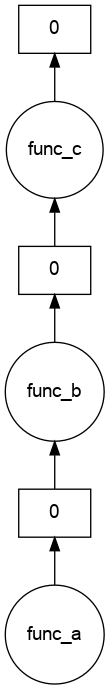

In [6]:
array.visualize()

In [7]:
result = array.compute()
print(result)

184


In [8]:
client.close()

### Example 8.2: Multi-node HighLevelGraph

In [1]:
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
from pprint import pprint
import numpy as np
from dask.array.core import Array

In [2]:
client = Client()

In [3]:
def func_a(x):
    return x**2


def func_b(x):
    return x**3


def func_c(x):
    return x + 120

In [4]:
# define highlevelgraph
layers = {
    "func_a": {
        ("func_a", 0): (func_a, 2),
        ("func_a", 1): (func_a, 3),
        ("func_a", 2): (func_a, 4),
    },
    "func_b": {
        ("func_b", 0): (func_b, ("func_a", 0)),
        ("func_b", 1): (func_b, ("func_a", 1)),
        ("func_b", 2): (func_b, ("func_a", 2)),
    },
    "func_c": {
        ("func_c", 0): (func_c, ("func_b", 0)),
        ("func_c", 1): (func_c, ("func_b", 1)),
        ("func_c", 2): (func_c, ("func_b", 2)),
    },
}
dependencies = {"func_a": set(), "func_b": {"func_a"}, "func_c": {"func_b"}}

hlg = HighLevelGraph(layers, dependencies)

In [5]:
# Create a Dask Array from the HighLevelGraph
array = Array(hlg, "func_c", shape=(3,), dtype=list, chunks=(1,))

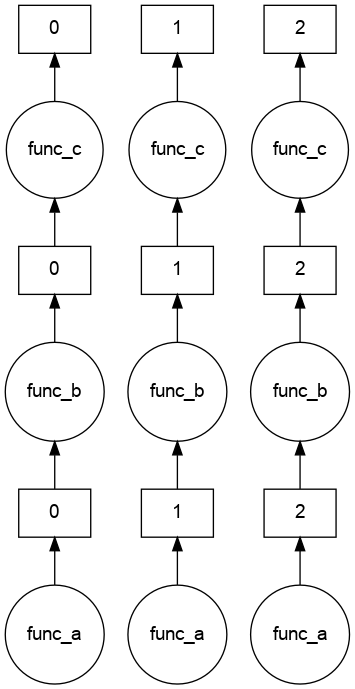

In [6]:
array.visualize()

In [7]:
array.compute()

array([ 184,  849, 4216])

In [8]:
client.close()

### Example 8.3: Explore layer nodes in each layer

In [156]:
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
from pprint import pprint
import numpy as np
from dask.array.core import Array
import hashlib

In [2]:
def func_a(x):
    return x**2


def func_b(x):
    return x**3


def func_c(x):
    return x + 120


def func_d(x):
    return x + 1

In [3]:
# define highlevelgraph
layers = {
    "func_a": {
        ("func_a", 0): (func_a, 2),
        ("func_a", 1): (func_a, 3),
        ("func_a", 2): (func_a, 4),
    },
    "func_b": {
        ("func_b", 0): (func_b, ("func_a", 0)),
        ("func_b", 1): (func_b, ("func_a", 1)),
        ("func_b", 2): (func_b, ("func_a", 2)),
    },
    "func_c": {
        ("func_c", 0): (func_c, ("func_b", 0)),
        ("func_c", 1): (func_c, ("func_b", 1)),
        ("func_c", 2): (func_c, ("func_b", 2)),
    },
}
dependencies = {"func_a": set(), "func_b": {"func_a"}, "func_c": {"func_b"}}

hlg = HighLevelGraph(layers, dependencies)

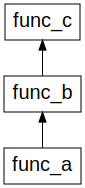

In [4]:
hlg.visualize()

In [5]:
pprint(hlg.to_dict())

{('func_a', 0): (<function func_a at 0x7efdccb7f5b0>, 2),
 ('func_a', 1): (<function func_a at 0x7efdccb7f5b0>, 3),
 ('func_a', 2): (<function func_a at 0x7efdccb7f5b0>, 4),
 ('func_b', 0): (<function func_b at 0x7efdccb7f640>, ('func_a', 0)),
 ('func_b', 1): (<function func_b at 0x7efdccb7f640>, ('func_a', 1)),
 ('func_b', 2): (<function func_b at 0x7efdccb7f640>, ('func_a', 2)),
 ('func_c', 0): (<function func_c at 0x7efdccb7f6d0>, ('func_b', 0)),
 ('func_c', 1): (<function func_c at 0x7efdccb7f6d0>, ('func_b', 1)),
 ('func_c', 2): (<function func_c at 0x7efdccb7f6d0>, ('func_b', 2))}


In [6]:
# Create a Dask Array from the HighLevelGraph
array = Array(hlg, "func_c", shape=(3,), dtype=list, chunks=(1,))

AttributeError: 'Array' object has no attribute 'to_dict'

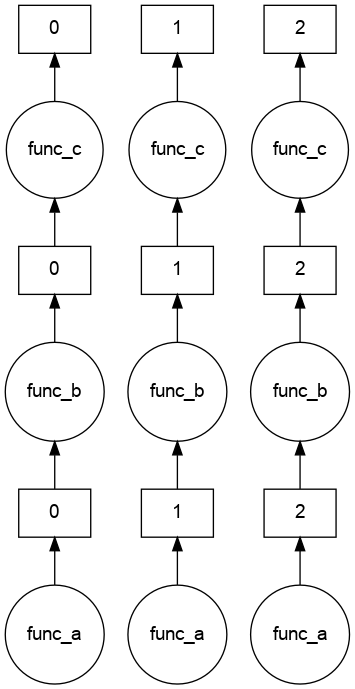

In [7]:
array.visualize()

In [8]:
array.dask.to_dict()

{('func_a', 0): (<function __main__.func_a(x)>, 2),
 ('func_a', 1): (<function __main__.func_a(x)>, 3),
 ('func_a', 2): (<function __main__.func_a(x)>, 4),
 ('func_b', 0): (<function __main__.func_b(x)>, ('func_a', 0)),
 ('func_b', 1): (<function __main__.func_b(x)>, ('func_a', 1)),
 ('func_b', 2): (<function __main__.func_b(x)>, ('func_a', 2)),
 ('func_c', 0): (<function __main__.func_c(x)>, ('func_b', 0)),
 ('func_c', 1): (<function __main__.func_c(x)>, ('func_b', 1)),
 ('func_c', 2): (<function __main__.func_c(x)>, ('func_b', 2))}

In [160]:
def modified_graph_to_futures(dsk, *args, **kwargs):
    c = datetime.now()
    print("Inside modified_graph_to_futures. Time = " + c.strftime("%H:%M:%S"))

    print(f"Dask Graph: {type(dsk)}")
    pprint(dsk)

    if not isinstance(dsk, HighLevelGraph):
        print(f"Converted to HighLevelGraph")
        dsk = HighLevelGraph.from_collections(id(dsk), dsk, dependencies=dict())
        print(dsk)

    info = dsk.to_dict()
    pprint(info)

    print("---------")
    print("Examining dictionary entries")
    for key, value in info.items():
        print(f"Key: {key}, Value: {value}")

        # excursively examine the values until they aren't tuple
        examine_value(value)

        print("---------")

    return original_graph_to_futures(dsk, *args, **kwargs)


def examine_value(value):
    print("Exploring value:", value)
    print("Type:", type(value))
    if type(value) == tuple:
        left = value[0]
        right = value[1]
        # left should be a function or a string
        if not callable(left) and not type(right) == tuple:
            final_left = left
            final_right = right
        else:
            if callable(left):
                # print(f'Function: {left.__name__}')
                final_left = left.__name__
                final_right = right

            if type(right) == tuple:
                examine_value(right)
                final_left = left.__name__
                final_right = right
            else:
                final_left = left.__name__
                final_right = right

    print("Layer Information")
    print("Left:", final_left)
    print("Right:", final_right)
    hash_name = str(final_left) + str(final_right)
    print("hash: " + hashlib.sha3_384(hash_name.encode()).hexdigest())

In [161]:
client = Client()

/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33013 instead
  warnings.warn(


In [162]:
original_graph_to_futures = client._graph_to_futures
client._graph_to_futures = modified_graph_to_futures

array.compute()

Inside modified_graph_to_futures. Time = 23:52:04
Dask Graph: <class 'dict'>
{('func_a-func_b-func_c', 0): (<function func_c at 0x7efdccb7f6d0>,
                               (<function func_b at 0x7efdccb7f640>,
                                (<function func_a at 0x7efdccb7f5b0>, 2))),
 ('func_a-func_b-func_c', 1): (<function func_c at 0x7efdccb7f6d0>,
                               (<function func_b at 0x7efdccb7f640>,
                                (<function func_a at 0x7efdccb7f5b0>, 3))),
 ('func_a-func_b-func_c', 2): (<function func_c at 0x7efdccb7f6d0>,
                               (<function func_b at 0x7efdccb7f640>,
                                (<function func_a at 0x7efdccb7f5b0>, 4))),
 ('func_c', 0): ('func_a-func_b-func_c', 0),
 ('func_c', 1): ('func_a-func_b-func_c', 1),
 ('func_c', 2): ('func_a-func_b-func_c', 2)}
Converted to HighLevelGraph
HighLevelGraph with 1 layers.
 0. 139624041726272

{('func_a-func_b-func_c', 0): (<function func_c at 0x7efdccb7f6d0>,
  

array([ 184,  849, 4216])

In [163]:
client.close()

2024-08-12 23:52:22,619 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
  File "/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/utils_comm.py", line 434, in retry
    return await coro()
  File "/software/swift-hep/envs/dask_dirac/lib/python3.

### Example 8.4: Using yield for getting the layer information

In [1]:
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
from pprint import pprint
import numpy as np
from dask.array.core import Array
import hashlib

In [64]:
def func_a(x):
    return x**2


def func_b(x):
    return x**3


def func_c(x):
    return x + 120


def func_a2():
    return 12

In [65]:
# define highlevelgraph
layers = {
    "func_a": {
        ("func_a", 0): (func_a, 2),
        ("func_a", 1): (func_a, 3),
        ("func_a", 2): (func_a, 4),
    },
    "func_b": {
        ("func_b", 0): (func_b, ("func_a", 0)),
        ("func_b", 1): (func_b, ("func_a", 1)),
        ("func_b", 2): (func_b, ("func_a", 2)),
    },
    "func_c": {
        ("func_c", 0): (func_c, ("func_b", 0)),
        ("func_c", 1): (func_c, ("func_b", 1)),
        ("func_c", 2): (func_c, ("func_b", 2)),
    },
}
dependencies = {"func_a": set(), "func_b": {"func_a"}, "func_c": {"func_b"}}

hlg = HighLevelGraph(layers, dependencies)

In [66]:
# Create a Dask Array from the HighLevelGraph
array = Array(hlg, "func_c", shape=(3,), dtype=list, chunks=(1,))

In [82]:
def modified_graph_to_futures(dsk, *args, **kwargs):
    c = datetime.now()
    print("Inside modified_graph_to_futures. Time = " + c.strftime("%H:%M:%S"))
    if not isinstance(dsk, HighLevelGraph):
        print(f"Converted to HighLevelGraph")
        dsk = HighLevelGraph.from_collections(id(dsk), dsk, dependencies=dict())

    info = dsk.to_dict()
    pprint(info)

    print("---------")
    print("Looping over dictionary entries")
    print("---------")
    new_info = {}
    for key, value in info.items():
        print(f"Key: {key}, Value: {value}")
        hash = generate_hash_from_value(value)
        print(f"final hash: {hash}")
        if (
            hash
            == "69504d960047ae6061fae26957b5c6ba6a5624434b16cd49f246539b192af184611c5582406b91a9a1f13e224ea4bdd4"
        ):
            new_info[key] = (func_c, (func_b, (func_a2,)))
        else:
            new_info[key] = value

        print("---------")

    dsk = HighLevelGraph.from_collections(id(new_info), new_info, dependencies=dict())
    pprint(dsk.to_dict())

    return original_graph_to_futures(dsk, *args, **kwargs)


def generate_hash_from_value(value):
    if isinstance(value, tuple):
        left = value[0]
        right = value[1]

        if callable(left):
            left_name = left.__name__
        else:
            left_name = str(left)

        if isinstance(right, tuple):
            right_hash = generate_hash_from_value(right)
        else:
            if callable(right):
                right_name = right.__name__
            else:
                right_name = str(right)
            right_hash = right_name

        # Combine the names/hashes
        combined = left_name + right_hash
        hash = hashlib.sha3_384(combined.encode()).hexdigest()
        print(f"hash inputs: {left_name} + {right_hash}")
        print(f"hash: {hash}")
        # TODO: check is hash matches with known hashes and if it does, replace callable with load function.
        return hash

    return str(value)

In [83]:
client = Client()

/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 12685 instead
  warnings.warn(


In [84]:
original_graph_to_futures = client._graph_to_futures
client._graph_to_futures = modified_graph_to_futures

array.compute()

Inside modified_graph_to_futures. Time = 21:56:52
Converted to HighLevelGraph
{('func_a-func_b-func_c', 0): (<function func_c at 0x7fd85844cdc0>,
                               (<function func_b at 0x7fd85844cd30>,
                                (<function func_a at 0x7fd858075870>, 2))),
 ('func_a-func_b-func_c', 1): (<function func_c at 0x7fd85844cdc0>,
                               (<function func_b at 0x7fd85844cd30>,
                                (<function func_a at 0x7fd858075870>, 3))),
 ('func_a-func_b-func_c', 2): (<function func_c at 0x7fd85844cdc0>,
                               (<function func_b at 0x7fd85844cd30>,
                                (<function func_a at 0x7fd858075870>, 4))),
 ('func_c', 0): ('func_a-func_b-func_c', 0),
 ('func_c', 1): ('func_a-func_b-func_c', 1),
 ('func_c', 2): ('func_a-func_b-func_c', 2)}
---------
Looping over dictionary entries
---------
Key: ('func_c', 0), Value: ('func_a-func_b-func_c', 0)
hash inputs: func_a-func_b-func_c + 0
has

array([ 184, 1848, 4216])

In [85]:
client.close()

### Example 8.5: Noting which layer has a hash that we know

In [68]:
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
import pprint
import numpy as np
from dask.array.core import Array
import hashlib

In [69]:
def func_a(x):
    return x**2


def func_b(x):
    return x**3


def func_c(x):
    return x + 120


def func_a2():
    return 50

In [70]:
# define highlevelgraph
layers = {
    "func_a": {
        ("func_a", 0): (func_a, 2),
        ("func_a", 1): (func_a, 3),
        ("func_a", 2): (func_a, 4),
    },
    "func_b": {
        ("func_b", 0): (func_b, ("func_a", 0)),
        ("func_b", 1): (func_b, ("func_a", 1)),
        ("func_b", 2): (func_b, ("func_a", 2)),
    },
    "func_c": {
        ("func_c", 0): (func_c, ("func_b", 0)),
        ("func_c", 1): (func_c, ("func_b", 1)),
        ("func_c", 2): (func_c, ("func_b", 2)),
    },
}
dependencies = {"func_a": set(), "func_b": {"func_a"}, "func_c": {"func_b"}}

hlg = HighLevelGraph(layers, dependencies)

In [71]:
# Create a Dask Array from the HighLevelGraph
array = Array(hlg, "func_c", shape=(3,), dtype=list, chunks=(1,))

In [72]:
def modified_graph_to_futures(dsk, *args, **kwargs):
    c = datetime.now()
    print("Inside modified_graph_to_futures. Time = " + c.strftime("%H:%M:%S"))
    if not isinstance(dsk, HighLevelGraph):
        print(f"Converted to HighLevelGraph")
        dsk = HighLevelGraph.from_collections(id(dsk), dsk, dependencies=dict())

    info = dsk.to_dict()
    pprint.pprint(info)

    print("---------")
    print("Looping over dictionary entries")
    print("---------")
    new_info = {}
    for key, value in info.items():
        print(f"Key: {key}, Value: {value}")
        _, hash_tuple = generate_hash_from_value(value)
        new_value = replace_hashed_functions(value, hash_tuple)
        new_info[key] = new_value
        print("New value:")
        pprint.pprint(new_value)

        print("---------")

    dsk = HighLevelGraph.from_collections(id(new_info), new_info, dependencies=dict())
    pprint.pprint(dsk.to_dict())

    return original_graph_to_futures(dsk, *args, **kwargs)


def generate_hash_from_value(value):
    if isinstance(value, tuple):
        left = value[0]
        right = value[1]

        # Process left side
        if callable(left):
            left_name = left.__name__
        else:
            left_name = str(left)

        # Process right side
        if isinstance(right, tuple):
            right_hash, this_tuple = generate_hash_from_value(right)
        else:
            if callable(right):
                right_name = right.__name__
            else:
                right_name = str(right)
            right_hash = right_name

        # Combine the names/hashes for final hash
        combined = left_name + right_hash
        final_hash = hashlib.sha3_384(combined.encode()).hexdigest()
        if "this_tuple" in locals():
            hash_tuple = (final_hash, this_tuple)
        else:
            hash_tuple = final_hash

        print(f"hash inputs: {left_name} + {right_hash}")
        print(f"hash: {final_hash}")
        print(f"hash tuple: {hash_tuple}")

        return final_hash, hash_tuple

    # should in theory never reach here
    return str(value), str(value)


def replace_hashed_functions(func_tuple, hash_tuple):
    global hash_list
    if isinstance(hash_tuple, tuple) and isinstance(func_tuple, tuple):
        current_hash, nested_hash = hash_tuple
        current_func, nested_func = func_tuple

        if current_hash in hash_list:
            return (func_a2,)
        else:
            # Recursively process the nested tuple
            modified_nested_func = replace_hashed_functions(nested_func, nested_hash)
            return (current_func, modified_nested_func)
    else:
        # Base case: No more nested tuples
        if hash_tuple in hash_list:
            return (func_a2,)
        else:
            return func_tuple

In [73]:
client = Client()

/software/swift-hep/envs/dask_dirac/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 31545 instead
  warnings.warn(


In [74]:
original_graph_to_futures = client._graph_to_futures
client._graph_to_futures = modified_graph_to_futures
hash_list = [
    "8fd76f289e82167addc62a0497edf1199b9cc0c1be1dab026f90260a490d6ce1a0c2dd4e8e1c30cff8991468bb238bdb"
]
array.compute()

Inside modified_graph_to_futures. Time = 15:23:18
Converted to HighLevelGraph
{('func_a-func_b-func_c', 0): (<function func_c at 0x7ff68057edd0>,
                               (<function func_b at 0x7ff68057c430>,
                                (<function func_a at 0x7ff68057c0d0>, 2))),
 ('func_a-func_b-func_c', 1): (<function func_c at 0x7ff68057edd0>,
                               (<function func_b at 0x7ff68057c430>,
                                (<function func_a at 0x7ff68057c0d0>, 3))),
 ('func_a-func_b-func_c', 2): (<function func_c at 0x7ff68057edd0>,
                               (<function func_b at 0x7ff68057c430>,
                                (<function func_a at 0x7ff68057c0d0>, 4))),
 ('func_c', 0): ('func_a-func_b-func_c', 0),
 ('func_c', 1): ('func_a-func_b-func_c', 1),
 ('func_c', 2): ('func_a-func_b-func_c', 2)}
---------
Looping over dictionary entries
---------
Key: ('func_c', 0), Value: ('func_a-func_b-func_c', 0)
hash inputs: func_a-func_b-func_c + 0
has

array([  50,  849, 4216])

In [75]:
client.close()

## Example 9: Complete examples

### Example 9.1: Example with numpy saving

In [1]:
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
import pprint
import numpy as np
from dask.array.core import Array
import hashlib
import copy
import dask
import dask.core
from collections import defaultdict
import glob
import time

In [2]:
def func_a(x):
    return x**2


def func_b(x):
    return x**3


def func_c(x):
    return x + 120


def func_d(x):
    return x + 14


def func_e(x, y):
    return x - y


def func_load(x):
    return np.load(
        "/users/ak18773/SWIFT_HEP/dask-dirac/examples/notebooks/data/" + x + ".npy"
    )


def func_save(x, arr):
    np.save(
        "/users/ak18773/SWIFT_HEP/dask-dirac/examples/notebooks/data/" + x + ".npy", arr
    )
    return arr

In [3]:
# define highlevelgraph
layers = {
    "func_a": {
        ("func_a", 0): (func_a, np.array([2])),
    },
    "func_b": {
        ("func_b", 0): (func_b, ("func_a", 0)),
    },
    "func_c": {
        ("func_c", 0): (func_c, np.array([2])),
    },
    "func_d": {
        ("func_d", 0): (func_d, ("func_c", 0)),
    },
    "func_e": {
        ("func_e", 0): (func_e, ("func_d", 0), ("func_b", 0)),
    },
}
dependencies = {
    "func_a": set(),
    "func_b": {"func_a"},
    "func_c": set(),
    "func_d": {"func_c"},
    "func_e": {"func_b", "func_d"},
}

hlg = HighLevelGraph(layers, dependencies)

In [4]:
# Create a Dask Array from the HighLevelGraph
array = Array(hlg, "func_e", shape=(1,), dtype=list, chunks=(1,))

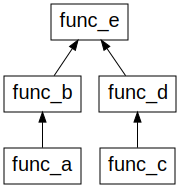

In [5]:
hlg.visualize()

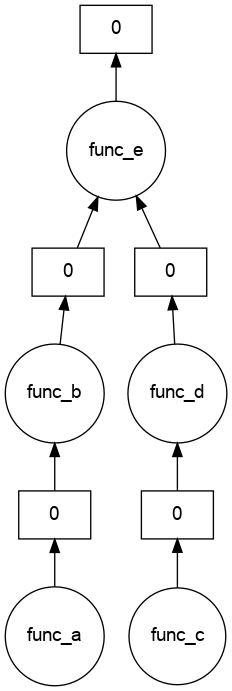

In [6]:
array.visualize()

In [7]:
def generate_hash_from_value(value):
    if isinstance(value, tuple):

        # Catch when there is no left and right as at end of chain
        if len(value) == 1:
            left = value[0]
            right = ""
        else:
            left = value[0]
            right = value[1:]
            if len(right) == 1:
                right = right[0]

        print(f"left: {left}")
        print(f"right: {right}")

        # Process left side
        if callable(left):
            left_name = left.__name__
        else:
            left_name = str(left)

        # Process right side
        if isinstance(right, tuple):
            print("rerunning function")
            print(f"left: {left}")
            print(f"right: {right}")
            right_hash, this_tuple = generate_hash_from_value(right)
        else:
            if callable(right):
                right_name = right.__name__
            else:
                right_name = str(right)
            right_hash = right_name

        # Combine the names/hashes for final hash
        combined = left_name + right_hash
        final_hash = hashlib.sha3_384(combined.encode()).hexdigest()
        if "this_tuple" in locals():
            hash_tuple = (final_hash, this_tuple)
        else:
            hash_tuple = final_hash

        print(f"hash inputs: {value}")
        print(f"hash inputs: {left_name} + {right_hash}")
        print(f"hash: {final_hash}")
        print(f"hash tuple: {hash_tuple}")

        return final_hash, hash_tuple

    # should in theory never reach here
    return str(value), str(value)

In [8]:
def modified_graph_to_futures(dsk, *args, **kwargs):
    c = datetime.now()
    print("Inside modified_graph_to_futures. Time = " + c.strftime("%H:%M:%S"))
    if not isinstance(dsk, HighLevelGraph):
        print(f"Converted to HighLevelGraph")
        dsk = HighLevelGraph.from_collections(id(dsk), dsk, dependencies=dict())

    info = dsk.to_dict()
    pprint.pprint(info)
    print("---------")
    key_list = info.keys()
    sorted_keys = dask.core.toposort(info)
    print("Processing keys in defined order")
    print(f"original list order: {key_list}")
    print(f"sorted key order: {sorted_keys}")
    print("---------")
    print("Looping over keys and calculating hashes")
    tmp_info = {}
    for key in sorted_keys:
        value = info[key]
        hash_tuple = None
        hash_base = None
        value_for_hash = value
        check_layer = True
        print(f"Key: {key}, Value: {value}")
        print(f"Checking if tmp_keys: {tmp_info.keys()}, are in {value}")
        for t_key in tmp_info.keys():
            if t_key in value:
                print(f"Found!")
                print(f"{t_key} in {value}")
                index = value.index(t_key)

                hash_base = tmp_info[t_key]["hash"]  # [index]
                temp_list = list(value_for_hash)
                temp_list[index] = hash_base
                value_for_hash = tuple(temp_list)
                print(hash_base)
                print(value_for_hash)
                print(index)
            elif t_key == value:
                print(f"Found!")
                print(f"{t_key} in {value}")
                hash_base = tmp_info[t_key]["hash"][0]
                check_layer = False
                hash_tuple = hash_base

        if hash_tuple is None:
            # Now we have the hash_base,
            _, hash_tuple = generate_hash_from_value(value_for_hash)

        tmp_info[key] = {"value": value, "hash": hash_tuple, "check_layer": check_layer}

        print("---------")

    pprint.pprint(tmp_info)

    # Now check layers that need to be checked, adding caching
    tmp_2 = {}
    for key in tmp_info.keys():
        print(f"Checking {key}... ")
        # Now we check if hash exist at some location
        input_func_tuple = tmp_info[key]["value"]
        input_hash_tuple = tmp_info[key]["hash"]
        if not tmp_info[key]["check_layer"]:
            print(f"Not processing layer")
            tmp_2[key] = input_func_tuple
        else:
            func_tuple = check_functions_and_hashes(input_func_tuple, input_hash_tuple)
            tmp_2[key] = func_tuple

        print(f"final_function_tuple")
        print(f"{func_tuple}")

    pprint.pprint(tmp_2)

    dsk = HighLevelGraph.from_collections(id(tmp_2), tmp_2, dependencies=dict())
    pprint.pprint(dsk.to_dict())

    return original_graph_to_futures(dsk, *args, **kwargs)


def check_functions_and_hashes(func_tuple, hash_tuple):
    print(f"Checking func_tuple: {func_tuple}")
    print(f"Checking hash_tuple: {hash_tuple}")
    cached_files = glob.glob(
        "/users/ak18773/SWIFT_HEP/dask-dirac/examples/notebooks/data/*.npy"
    )
    cached_files = [c[c.rfind("/") + 1 : -4] for c in cached_files]

    if len(func_tuple) > 2:
        print("Need to think about how to do this, but for now just check first hash")
        if hash_tuple[0] in cached_files:
            return (func_load, hash_tuple[0])
        else:
            return (func_save, hash_tuple[0], (func_tuple))

    # Get to the deepest level and replace

    if isinstance(hash_tuple, tuple) and isinstance(func_tuple, tuple):
        current_hash, nested_hash = hash_tuple
        current_func, nested_func = func_tuple

        if current_hash in cached_files:
            return (func_load, current_hash)
        else:
            # Recursively process the nested tuple
            modified_nested_func = check_functions_and_hashes(nested_func, nested_hash)
            return (func_save, current_hash, (current_func, modified_nested_func))
    else:
        # Base case: No more nested tuples
        if hash_tuple in cached_files:
            return (func_load, hash_tuple)
        else:
            return (func_save, hash_tuple, (func_tuple))

In [13]:
client = Client()

In [14]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 15.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:20463,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 15.14 GiB
Comm: tcp://127.0.0.1:11053,Total threads: 2
Dashboard: http://127.0.0.1:30071/status,Memory: 5.05 GiB
Nanny: tcp://127.0.0.1:27359,


In [15]:
original_graph_to_futures = client._graph_to_futures
client._graph_to_futures = modified_graph_to_futures
hash_list = []
array.compute()

Inside modified_graph_to_futures. Time = 13:51:34
Converted to HighLevelGraph
{('func_a-func_b', 0): (<function func_b at 0x7fa7187a7880>,
                        (<function func_a at 0x7fa7187a77f0>, array([2]))),
 ('func_b', 0): ('func_a-func_b', 0),
 ('func_c-func_d', 0): (<function func_d at 0x7fa7187a7a30>,
                        (<function func_c at 0x7fa7187a79a0>, array([2]))),
 ('func_d', 0): ('func_c-func_d', 0),
 ('func_e', 0): (<function func_e at 0x7fa7187a7ac0>,
                 ('func_d', 0),
                 ('func_b', 0))}
---------
Processing keys in defined order
original list order: dict_keys([('func_e', 0), ('func_b', 0), ('func_d', 0), ('func_c-func_d', 0), ('func_a-func_b', 0)])
sorted key order: [('func_c-func_d', 0), ('func_d', 0), ('func_a-func_b', 0), ('func_b', 0), ('func_e', 0)]
---------
Looping over keys and calculating hashes
Key: ('func_c-func_d', 0), Value: (<function func_d at 0x7fa7187a7a30>, (<function func_c at 0x7fa7187a79a0>, array([2])))
Checki

array([72])

In [16]:
client.close()

### Example 9.2: Example with parquet

In [2]:
from datetime import datetime
from dask.distributed import Client
from dask.highlevelgraph import HighLevelGraph
import pprint
import numpy as np
from dask.array.core import Array
import hashlib
import copy
import dask
import dask.core
from collections import defaultdict
import glob
import time
import pandas as pd

In [3]:
def func_a(x):
    return x**2


def func_b(x):
    return x**3


def func_c(x):
    return x + 120


def func_d(x):
    return x + 14


def func_e(x, y):
    return x - y

In [4]:
def save_to_parquet(filename: str, data: pd.DataFrame) -> pd.DataFrame:
    """Save data to Parquet file."""
    name = cache_location + "/" + filename + ".parquet"
    # ensure dataframe columns have names
    if not all(isinstance(col, str) for col in data.columns):
        data.columns = [f"col_{i}" for i in range(data.shape[1])]
    data.to_parquet(name)
    return data


def load_from_parquet(filename: str) -> pd.DataFrame:
    """Load data from Parquet file."""
    name = cache_location + "/" + filename + ".parquet"
    return pd.read_parquet(name)

In [5]:
# define highlevelgraph
param_a = pd.DataFrame(np.array([2]))
param_b = pd.DataFrame(np.array([2]))

layers = {
    "func_a": {
        ("func_a", 0): (func_a, param_a),
    },
    "func_b": {
        ("func_b", 0): (func_b, ("func_a", 0)),
    },
    "func_c": {
        ("func_c", 0): (func_c, param_b),
    },
    "func_d": {
        ("func_d", 0): (func_d, ("func_c", 0)),
    },
    "func_e": {
        ("func_e", 0): (func_e, ("func_d", 0), ("func_b", 0)),
    },
}
dependencies = {
    "func_a": set(),
    "func_b": {"func_a"},
    "func_c": set(),
    "func_d": {"func_c"},
    "func_e": {"func_b", "func_d"},
}

hlg = HighLevelGraph(layers, dependencies)

In [6]:
array = Array(hlg, "func_e", shape=(1,), dtype=list, chunks=(1,))

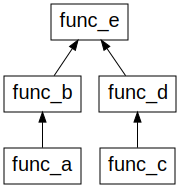

In [7]:
hlg.visualize()

In [8]:
def generate_hash_from_value(value):
    if isinstance(value, tuple):

        # Catch when there is no left and right as at end of chain
        if len(value) == 1:
            left = value[0]
            right = ""
        else:
            left = value[0]
            right = value[1:]
            if len(right) == 1:
                right = right[0]

        print(f"left: {left}")
        print(f"right: {right}")

        # Process left side
        if callable(left):
            left_name = left.__name__
        else:
            left_name = str(left)

        # Process right side
        if isinstance(right, tuple):
            print("rerunning function")
            print(f"left: {left}")
            print(f"right: {right}")
            right_hash, this_tuple = generate_hash_from_value(right)
        else:
            if callable(right):
                right_name = right.__name__
            else:
                right_name = str(right)
            right_hash = right_name

        # Combine the names/hashes for final hash
        combined = left_name + right_hash
        final_hash = hashlib.sha3_384(combined.encode()).hexdigest()
        if "this_tuple" in locals():
            hash_tuple = (final_hash, this_tuple)
        else:
            hash_tuple = final_hash

        print(f"hash inputs: {value}")
        print(f"hash inputs: {left_name} + {right_hash}")
        print(f"hash: {final_hash}")
        print(f"hash tuple: {hash_tuple}")

        return final_hash, hash_tuple

    # should in theory never reach here
    return str(value), str(value)

In [9]:
def modified_graph_to_futures(dsk, *args, **kwargs):
    c = datetime.now()
    print("Inside modified_graph_to_futures. Time = " + c.strftime("%H:%M:%S"))
    if not isinstance(dsk, HighLevelGraph):
        print(f"Converted to HighLevelGraph")
        dsk = HighLevelGraph.from_collections(id(dsk), dsk, dependencies=dict())

    info = dsk.to_dict()
    pprint.pprint(info)
    print("---------")
    key_list = info.keys()
    sorted_keys = dask.core.toposort(info)
    print("Processing keys in defined order")
    print(f"original list order: {key_list}")
    print(f"sorted key order: {sorted_keys}")
    print("---------")
    print("Looping over keys and calculating hashes")
    tmp_info = {}
    for key in sorted_keys:
        value = info[key]
        hash_tuple = None
        hash_base = None
        value_for_hash = value
        check_layer = True
        print(f"Key: {key}, Value: {value}")
        print(f"Checking if tmp_keys: {tmp_info.keys()}, are in {value}")
        for t_key in tmp_info.keys():
            if t_key in value:
                print(f"Found!")
                print(f"{t_key} in {value}")
                index = value.index(t_key)

                hash_base = tmp_info[t_key]["hash"]  # [index]
                temp_list = list(value_for_hash)
                temp_list[index] = hash_base
                value_for_hash = tuple(temp_list)
                print(hash_base)
                print(value_for_hash)
                print(index)
            elif t_key == value:
                print(f"Found!")
                print(f"{t_key} in {value}")
                hash_base = tmp_info[t_key]["hash"][0]
                check_layer = False
                hash_tuple = hash_base

        if hash_tuple is None:
            # Now we have the hash_base,
            _, hash_tuple = generate_hash_from_value(value_for_hash)

        tmp_info[key] = {"value": value, "hash": hash_tuple, "check_layer": check_layer}

        print("---------")

    pprint.pprint(tmp_info)

    # Now check layers that need to be checked, adding caching
    tmp_2 = {}
    for key in tmp_info.keys():
        print(f"Checking {key}... ")
        # Now we check if hash exist at some location
        input_func_tuple = tmp_info[key]["value"]
        input_hash_tuple = tmp_info[key]["hash"]
        if not tmp_info[key]["check_layer"]:
            print(f"Not processing layer")
            tmp_2[key] = input_func_tuple
        else:
            func_tuple = check_functions_and_hashes(input_func_tuple, input_hash_tuple)
            tmp_2[key] = func_tuple

        print(f"final_function_tuple")
        print(f"{func_tuple}")

    pprint.pprint(tmp_2)

    dsk = HighLevelGraph.from_collections(id(tmp_2), tmp_2, dependencies=dict())
    pprint.pprint(dsk.to_dict())

    return original_graph_to_futures(dsk, *args, **kwargs)


def check_functions_and_hashes(func_tuple, hash_tuple):
    print(f"Checking func_tuple: {func_tuple}")
    print(f"Checking hash_tuple: {hash_tuple}")
    cached_files = glob.glob(cache_location + "/*.parquet")
    cached_files = [c[c.rfind("/") + 1 : -4] for c in cached_files]

    if len(func_tuple) > 2:
        print("Need to think about how to do this, but for now just check first hash")
        if hash_tuple[0] in cached_files:
            return (load_from_parquet, hash_tuple[0])
        else:
            return (save_to_parquet, hash_tuple[0], (func_tuple))

    # Get to the deepest level and replace

    if isinstance(hash_tuple, tuple) and isinstance(func_tuple, tuple):
        current_hash, nested_hash = hash_tuple
        current_func, nested_func = func_tuple

        if current_hash in cached_files:
            return (load_from_parquet, current_hash)
        else:
            # Recursively process the nested tuple
            modified_nested_func = check_functions_and_hashes(nested_func, nested_hash)
            return (save_to_parquet, current_hash, (current_func, modified_nested_func))
    else:
        # Base case: No more nested tuples
        if hash_tuple in cached_files:
            return (load_from_parquet, hash_tuple)
        else:
            return (save_to_parquet, hash_tuple, (func_tuple))

In [10]:
client = Client()

In [11]:
cache_location = "/users/ak18773/SWIFT_HEP/dask-dirac/examples/notebooks/data"

In [12]:
if "cache_location" not in locals():
    print("cache_location not defined. Not running")
else:
    original_graph_to_futures = client._graph_to_futures
    client._graph_to_futures = modified_graph_to_futures
    b = array.compute()

Inside modified_graph_to_futures. Time = 16:42:20
Converted to HighLevelGraph
{('func_a-func_b', 0): (<function func_b at 0x7fc8d005e9e0>,
                        (<function func_a at 0x7fc945b0bb50>,    0
0  2)),
 ('func_b', 0): ('func_a-func_b', 0),
 ('func_c-func_d', 0): (<function func_d at 0x7fc8d005eb00>,
                        (<function func_c at 0x7fc8d005ea70>,    0
0  2)),
 ('func_d', 0): ('func_c-func_d', 0),
 ('func_e', 0): (<function func_e at 0x7fc8d005eb90>,
                 ('func_d', 0),
                 ('func_b', 0))}
---------
Processing keys in defined order
original list order: dict_keys([('func_e', 0), ('func_d', 0), ('func_b', 0), ('func_a-func_b', 0), ('func_c-func_d', 0)])
sorted key order: [('func_c-func_d', 0), ('func_d', 0), ('func_a-func_b', 0), ('func_b', 0), ('func_e', 0)]
---------
Looping over keys and calculating hashes
Key: ('func_c-func_d', 0), Value: (<function func_d at 0x7fc8d005eb00>, (<function func_c at 0x7fc8d005ea70>,    0
0  2))
Checking 

In [15]:
client.close()